In [42]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

import pandas as pd

df_ohe_final = pd.read_pickle("/content/drive/MyDrive/df_ohe_final.pkl")
df_ohe_final.head()

with open("/content/drive/MyDrive/onehot_encoder.pkl", "rb") as f:
    enc = pickle.load(f)

print("OneHotEncoder loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OneHotEncoder loaded.


In [43]:
df_ohe_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35121 entries, 0 to 35120
Columns: 103 entries, title to country_grouped_Unknown
dtypes: category(4), float64(17), object(6), uint8(76)
memory usage: 9.1+ MB


In [44]:
# --- Imports ---
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -----------------------------
# 1) Define target and features
# -----------------------------
TARGET = "normalized_salary"

# Keep only numeric columns (drop text leftovers that break sklearn)
num_cols = df_ohe_final.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)

X = df_ohe_final[num_cols].copy()
y = df_ohe_final[TARGET].astype(float).copy()

# --------------------------------------------
# 2) Optional: drop ultra-rare / near-constant
# --------------------------------------------
# Remove features that are (almost) constant: threshold=0 removes exactly-constant;
# slightly >0 will drop near-constants too (tune if needed).
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X)
kept_vt_mask = vt.get_support()
kept_vt_cols = [c for c, keep in zip(X.columns, kept_vt_mask) if keep]

X = pd.DataFrame(X_vt, columns=kept_vt_cols, index=X.index)

# ------------------------------------------------
# 3) Train/test split (no stratify for regression)
# ------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 4) Scale numeric feature data
# -----------------------------
# Standardize features: improves L1/L2 optimizers and cuts ConvergenceWarnings
scaler = StandardScaler(with_mean=True, with_std=True)
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)

# -----------------------------------------
# 5) LASSO with cross-validation (robust cv)
# -----------------------------------------
# Increase max_iter to reduce convergence warnings; n_alphas provides a good path resolution
lasso = LassoCV(
    alphas=None,            # let CV choose grid
    n_alphas=100,
    cv=5,
    max_iter=100000,
    n_jobs=-1,
    random_state=42
)
lasso.fit(X_tr_sc, y_tr)

y_pred_tr = lasso.predict(X_tr_sc)
y_pred_te = lasso.predict(X_te_sc)

# Metrics; RMSE is computed via sqrt(MSE) to avoid 'squared' kw issues
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_te, y_pred_te))

print("[LASSO] alpha_*:", lasso.alpha_)
print(f"[LASSO] R2 train: {r2_score(y_tr, y_pred_tr):.4f}")
print(f"[LASSO] R2 test:  {r2_score(y_te, y_pred_te):.4f}")
print(f"[LASSO] MAE test: {mean_absolute_error(y_te, y_pred_te):.2f}")
print(f"[LASSO] RMSE test:{rmse_te:.2f}")

# Non-zero coefficients as feature importance proxy
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
imp_lasso = lasso_coef[lasso_coef != 0].sort_values(key=np.abs, ascending=False)
print("\n[LASSO] Top features:")
print(imp_lasso.head(25))

# ----------------------------------------------------
# 6) ElasticNetCV (often more stable than pure LASSO)
# ----------------------------------------------------
enet = ElasticNetCV(
    l1_ratio=[0.2, 0.5, 0.8, 0.9, 0.95, 1.0],  # 1.0 == LASSO
    cv=5,
    n_jobs=-1,
    max_iter=100000,
    random_state=42
)
enet.fit(X_tr_sc, y_tr)

y_pred_te_en = enet.predict(X_te_sc)
rmse_te_en = np.sqrt(mean_squared_error(y_te, y_pred_te_en))

print("\n[ElasticNet] best l1_ratio:", enet.l1_ratio_)
print("[ElasticNet] alpha_*:", enet.alpha_)
print(f"[ElasticNet] R2 test:  {r2_score(y_te, y_pred_te_en):.4f}")
print(f"[ElasticNet] MAE test: {mean_absolute_error(y_te, y_pred_te_en):.2f}")
print(f"[ElasticNet] RMSE test:{rmse_te_en:.2f}")

enet_coef = pd.Series(enet.coef_, index=X.columns)
imp_enet = enet_coef[enet_coef != 0].sort_values(key=np.abs, ascending=False)
print("\n[ElasticNet] Top features:")
print(imp_enet.head(25))

# ---------------------------------------------------------
# 7) Persist the trained scaler + models for later re-use
# ---------------------------------------------------------
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("lasso_model.pkl", "wb") as f:
    pickle.dump(lasso, f)

with open("elasticnet_model.pkl", "wb") as f:
    pickle.dump(enet, f)

# (Optional) Save selected/kept feature names for reproducible pipelines
pd.Series(X.columns).to_csv("kept_features_after_vt.csv", index=False)


[LASSO] alpha_*: 39.32139094765402
[LASSO] R2 train: 0.7179
[LASSO] R2 test:  0.7204
[LASSO] MAE test: 16721.10
[LASSO] RMSE test:25009.46

[LASSO] Top features:
max_salary                                            31493.503609
med_salary                                            24655.247936
pay_period_YEARLY                                    -17743.135798
min_salary                                            17233.489543
industry_group_15_Tech & Internet                    -11633.360196
industry_group_15_Healthcare & Life Sciences           8837.386365
formatted_work_type_contract                           7296.460606
pay_period_HOURLY                                      6620.923776
formatted_experience_level_Mid-Senior level            6481.409035
industry_group_15_Finance & Insurance                 -6176.957019
industry_group_15_Retail & Wholesale                   5092.527155
formatted_experience_level_Director                    3761.934626
industry_group_15_Manufacturing   

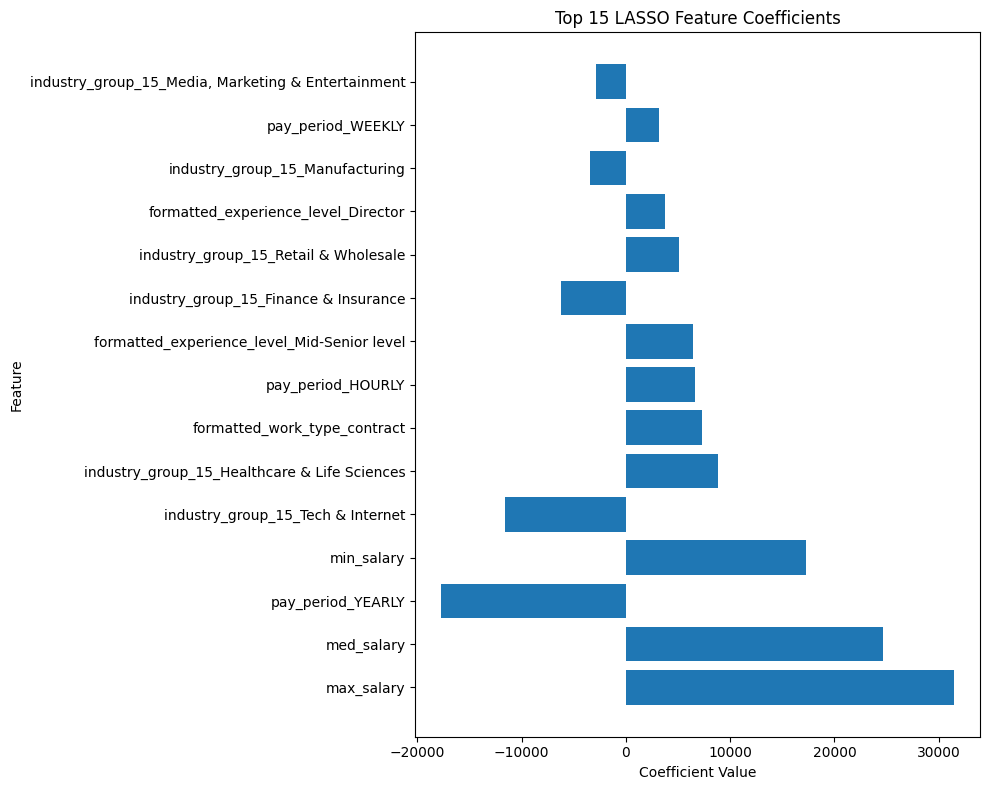

In [45]:
import matplotlib.pyplot as plt

# top 15 features from LASSO (exact values you provided)
top_features = {
    "max_salary": 31493.503609,
    "med_salary": 24655.247936,
    "pay_period_YEARLY": -17743.135798,
    "min_salary": 17233.489543,
    "industry_group_15_Tech & Internet": -11633.360196,
    "industry_group_15_Healthcare & Life Sciences": 8837.386365,
    "formatted_work_type_contract": 7296.460606,
    "pay_period_HOURLY": 6620.923776,
    "formatted_experience_level_Mid-Senior level": 6481.409035,
    "industry_group_15_Finance & Insurance": -6176.957019,
    "industry_group_15_Retail & Wholesale": 5092.527155,
    "formatted_experience_level_Director": 3761.934626,
    "industry_group_15_Manufacturing": -3429.172236,
    "pay_period_WEEKLY": 3184.867225,
    "industry_group_15_Media, Marketing & Entertainment": -2862.140381
}

plt.figure(figsize=(10, 8))
plt.barh(list(top_features.keys()), list(top_features.values()))
plt.title("Top 15 LASSO Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [46]:
cols_to_drop = ["max_salary", "med_salary", "min_salary"]
df_no_leak = df_ohe_final.drop(columns=cols_to_drop)


In [47]:
# --- Feature Engineering (idempotent) ---
import numpy as np

assert 'df_no_leak' in globals(), "df_no_leak must exist (comes right after the drop of salary columns)."

# 1) Log followers (stable even if already exists)
if 'follower_count' in df_no_leak.columns:
    df_no_leak['follower_log'] = np.log1p(df_no_leak['follower_count'])

# 2) Days to expiry (milliseconds -> days), clipped to non-negative
if {'expiry','listed_time'}.issubset(df_no_leak.columns):
    ms_per_day = 24*3600*1000
    df_no_leak['days_to_expiry'] = ((df_no_leak['expiry'] - df_no_leak['listed_time'])/ms_per_day).clip(lower=0)

# 3) Seniority score (use existing; otherwise derive from dummies if available)
if 'seniority_score' not in df_no_leak.columns:
    mapping = {
        'formatted_experience_level_Internship'      : 0,
        'formatted_experience_level_Entry level'     : 1,
        'formatted_experience_level_Associate'       : 2,
        'formatted_experience_level_Mid-Senior level': 3,
        'formatted_experience_level_Director'        : 4,
        'formatted_experience_level_Executive'       : 5,
    }
    df_no_leak['seniority_score'] = 0
    for col, score in mapping.items():
        if col in df_no_leak.columns:
            # where dummy==1 -> take score, else keep existing
            df_no_leak['seniority_score'] = np.where(df_no_leak[col].astype(int)==1, score, df_no_leak['seniority_score'])

# 4) Interaction: seniority × Tech & Internet (0 if column missing)
tech_col = 'industry_group_15_Tech & Internet'
if tech_col in df_no_leak.columns:
    df_no_leak['seniority_industry_interaction'] = df_no_leak['seniority_score'] * df_no_leak[tech_col].astype(int)
else:
    df_no_leak['seniority_industry_interaction'] = 0

# sanity check
added = ['follower_log','days_to_expiry','seniority_score','seniority_industry_interaction']
present = [c for c in added if c in df_no_leak.columns]
print("Added features present:", present)
display(df_no_leak[present].head())
print("Shape after FE:", df_no_leak.shape)


Added features present: ['follower_log', 'days_to_expiry', 'seniority_score', 'seniority_industry_interaction']


,follower_log,days_to_expiry,seniority_score,seniority_industry_interaction
0,7.763021,30.0,3,0
1,10.527124,30.0,3,0
2,3.713572,30.0,1,0
3,7.794823,30.0,3,0
4,10.527124,30.0,3,0


Shape after FE: (35121, 104)


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=50000))
])


In [49]:
import numpy as np
alphas = np.linspace(20, 60, 40)  # zoom-in around alpha=39

lasso_grid = LassoCV(alphas=alphas, cv=5, n_jobs=-1, max_iter=50000)


In [9]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(
#     n_estimators=300,
#     max_depth=None,
#     random_state=42,
#     n_jobs=-1
# )


# rf.fit(X_train, y_train)


In [10]:
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# import numpy as np

# pred_rf = rf.predict(X_test)

# print("RF R2:", r2_score(y_test, pred_rf))
# print("RF MAE:", mean_absolute_error(y_test, pred_rf))
# print("RF RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))


In [50]:
df_no_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35121 entries, 0 to 35120
Columns: 104 entries, title to seniority_industry_interaction
dtypes: category(4), float64(16), int64(2), object(6), uint8(76)
memory usage: 9.4+ MB


In [51]:
df_no_leak["skills_count"] = df_no_leak["job_skills"].apply(lambda x: len(str(x).split(",")))


In [52]:
df_no_leak["industry_count"] = df_no_leak["job_industries"].apply(lambda x: len(str(x).split(",")))

benefit_cols = [col for col in df_no_leak.columns if col.startswith("job_benefit_categories_")]
df_no_leak["benefits_count"] = df_no_leak[benefit_cols].sum(axis=1)


In [53]:
df_no_leak["days_to_expiry"] = df_no_leak["expiry"] - df_no_leak["listed_time"]


In [54]:
df_no_leak["follower_log"] = np.log1p(df_no_leak["follower_count"])


In [55]:
city_counts = df_no_leak["city"].value_counts()
rare_cities = city_counts[city_counts < 50].index
df_no_leak["city_rare"] = df_no_leak["city"].isin(rare_cities).astype(int)


In [56]:
mapping = {
    "Internship": 0,
    "Entry level": 1,
    "Associate": 2,
    "Mid-Senior level": 3,
    "Director": 4,
    "Executive": 5
}

df_no_leak["seniority_score"] = (
    df_no_leak[[
        col for col in df_no_leak.columns
        if col.startswith("formatted_experience_level_")
    ]]
    .idxmax(axis=1)
    .str.replace("formatted_experience_level_", "")
    .map(mapping)
)


In [57]:
# --- Ensure engineered features exist on df_no_leak ---

import numpy as np
import pandas as pd

assert "df_no_leak" in globals(), "df_no_leak is missing – make sure you dropped the salary columns earlier."

# seniority_score (create only if you have a parsable source; else leave as-is if it already exists)
# If you already created 'seniority_score' earlier, this will just skip.
if "seniority_score" not in df_no_leak.columns:
    # Try to derive from a 'title' column as a simple heuristic, otherwise fill 0
    def _seniority_from_title(txt):
        t = str(txt).lower()
        if any(k in t for k in ["exec", "vp", "chief", "cto", "ceo", "cfo"]):
            return 5
        if any(k in t for k in ["director", "head"]):
            return 4
        if any(k in t for k in ["lead", "principal", "sr", "senior"]):
            return 3
        if any(k in t for k in ["mid", "associate"]):
            return 2
        if any(k in t for k in ["junior", "intern", "entry"]):
            return 1
        return 2  # default mid
    src_col = "title" if "title" in df_no_leak.columns else None
    df_no_leak["seniority_score"] = df_no_leak[src_col].apply(_seniority_from_title) if src_col else 2

# days_to_expiry
if "days_to_expiry" not in df_no_leak.columns:
    if {"expiry","listed_time"}.issubset(df_no_leak.columns):
        df_no_leak["days_to_expiry"] = ((df_no_leak["expiry"] - df_no_leak["listed_time"]) / (60*60*24)).clip(lower=0)
    else:
        df_no_leak["days_to_expiry"] = 0

# follower_log
if "follower_log" not in df_no_leak.columns:
    base = df_no_leak["follower_count"] if "follower_count" in df_no_leak.columns else 0
    df_no_leak["follower_log"] = np.log1p(base)

# seniority_industry_interaction  (interaction: seniority x Tech&Internet)
tech_col = "industry_group_15_Tech & Internet"
if tech_col in df_no_leak.columns:
    df_no_leak["seniority_industry_interaction"] = df_no_leak["seniority_score"] * df_no_leak[tech_col]
else:
    df_no_leak["seniority_industry_interaction"] = df_no_leak["seniority_score"] * 0

# Fill any NaNs introduced
for c in ["seniority_score","days_to_expiry","follower_log","seniority_industry_interaction"]:
    if c in df_no_leak.columns:
        df_no_leak[c] = pd.to_numeric(df_no_leak[c], errors="coerce").fillna(0)

print("Created/verified engineered features:",
      [c for c in ["seniority_score","days_to_expiry","follower_log","seniority_industry_interaction"] if c in df_no_leak.columns])
print("df_no_leak shape now:", df_no_leak.shape)


Created/verified engineered features: ['seniority_score', 'days_to_expiry', 'follower_log', 'seniority_industry_interaction']
df_no_leak shape now: (35121, 108)


In [58]:
# Remove location/date leakage-like proxy features
cols_proxy = [
    "zip_code",
    "fips",
    "expiry",
    "original_listed_time",
    "listed_time"
]

df_clean = df_no_leak.drop(columns=cols_proxy)
print("Removed proxy columns. New shape:", df_clean.shape)
df_clean.head()


Removed proxy columns. New shape: (35121, 103)


,title,description,job_skills,job_industries,normalized_salary,views,listed_year,listed_month,expiry_year,expiry_month,...,country_grouped_US,country_grouped_Unknown,follower_log,days_to_expiry,seniority_score,seniority_industry_interaction,skills_count,industry_count,benefits_count,city_rare
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing; Sales,Real Estate,38480.0,4.0,2024.0,4.0,2024.0,5.0,...,1,0,7.763021,2.592000e+09,3,0,1,1,1,1
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Health Care Provider,Unknown,83200.0,1.0,2024.0,4.0,2024.0,5.0,...,0,1,10.527124,2.592000e+09,3,0,1,1,1,0
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,Management; Manufacturing,Restaurants,55000.0,8.0,2024.0,4.0,2024.0,5.0,...,1,0,3.713572,2.592000e+09,1,0,1,1,1,1
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Other,Law Practice,157500.0,4.0,2024.0,4.0,2024.0,5.0,...,1,0,7.794823,2.592000e+09,3,0,1,1,1,1
4,Service Technician,Looking for HVAC service tech with experience ...,Information Technology,Facilities Services,70000.0,3.0,2024.0,4.0,2024.0,5.0,...,0,1,10.527124,2.592000e+09,3,0,1,1,1,0


In [59]:
TARGET = "normalized_salary"

y = df_clean[TARGET]
X = df_clean.drop(columns=[TARGET])

# Keep only numeric columns
X = X.select_dtypes(include=["number"])

print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (35121, 92)
y shape: (35121,)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((28096, 92), (7025, 92))

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [62]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LassoCV(cv=5, max_iter=50000, n_jobs=-1))])

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print("LASSO R2 train:", r2_score(y_train, pred_train))
print("LASSO R2 test:", r2_score(y_test, pred_test))
print("LASSO MAE:", mean_absolute_error(y_test, pred_test))
print("LASSO RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

print("Chosen alpha:", pipe.named_steps["model"].alpha_)


LASSO R2 train: 0.3926031725841854
LASSO R2 test: 0.39942163005955134
LASSO MAE: 27889.842987240336
LASSO RMSE: 36654.46692299907
Chosen alpha: 66.91424650425795


In [64]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [65]:
pred_rf = rf.predict(X_test)

print("RF R2:", r2_score(y_test, pred_rf))
print("RF MAE:", mean_absolute_error(y_test, pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))


RF R2: 0.4913746659725804
RF MAE: 24316.90841642926
RF RMSE: 33731.919747707274


In [66]:
import pandas as pd

importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(20)


,0
seniority_score,0.215110
pay_period_YEARLY,0.089262
views,0.081553
follower_log,0.079328
follower_count,0.079013
formatted_work_type_contract,0.040073
days_to_expiry,0.033520
remote_allowed_dummy,0.018375
state_region_5_West,0.017633
city_rare,0.014209


In [68]:
df_clean["seniority_industry_interaction"] = (
    df_clean["seniority_score"] *
    df_clean["industry_group_15_Tech & Internet"]
)


In [69]:
df_clean["seniority_company_interaction"] = (
    df_clean["seniority_score"] * df_no_leak["follower_log"]
)


In [70]:
df_clean["seniority_skills_interaction"] = (
    df_clean["seniority_score"] * df_no_leak["skills_count"]
)


In [71]:
df_clean["seniority_benefits_interaction"] = (
    df_clean["seniority_score"] * df_no_leak["benefits_count"]
)


In [72]:
X = df_clean.drop(columns=["normalized_salary"])
X = X.select_dtypes(include=["number"])


In [73]:
# --- Define target/feature matrix (numeric-only) ---

TARGET = "normalized_salary"
y = df_clean[TARGET].astype("float32")

# Start from all columns except target, then keep numeric dtypes only
X = (
    df_clean.drop(columns=[TARGET])
              .select_dtypes(include=["number"])
              .replace([np.inf, -np.inf], np.nan)
              .fillna(0.0)
              .astype("float32")
)

print(X.shape, "features after numeric filter")


(35121, 95) features after numeric filter


In [74]:
# --- Train/test split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(28096, 95) (7025, 95)


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Fit new RandomForest on cleaned dataset
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print("RF R2:", r2_score(y_test, pred))
print("RF MAE:", mean_absolute_error(y_test, pred))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


RF R2: 0.49369975710807434
RF MAE: 24268.584934230836
RF RMSE: 33654.7316731879


In [76]:
# RMSE without 'squared' argument + show top 20 feature importances
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RF RMSE:", rmse)

# Top 20 features by importance
feat_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 20 features:")
feat_importance.head(20)


RF RMSE: 33654.7316731879

Top 20 features:


,0
pay_period_YEARLY,0.090376
seniority_company_interaction,0.087612
views,0.080041
seniority_score,0.070936
seniority_benefits_interaction,0.066368
seniority_skills_interaction,0.063278
follower_count,0.052965
follower_log,0.052738
formatted_work_type_contract,0.039557
days_to_expiry,0.032579


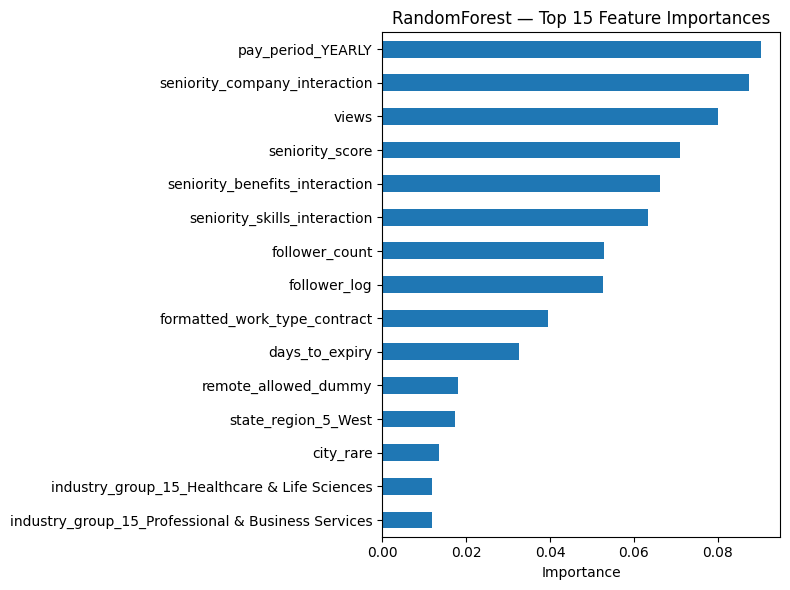

Saved figure: rf_top15_importances.png
pay_period_YEARLY                                     0.090376
seniority_company_interaction                         0.087612
views                                                 0.080041
seniority_score                                       0.070936
seniority_benefits_interaction                        0.066368
seniority_skills_interaction                          0.063278
follower_count                                        0.052965
follower_log                                          0.052738
formatted_work_type_contract                          0.039557
days_to_expiry                                        0.032579
remote_allowed_dummy                                  0.017963
state_region_5_West                                   0.017360
city_rare                                             0.013574
industry_group_15_Healthcare & Life Sciences          0.011908
industry_group_15_Professional & Business Services    0.011820
dtype: float64


In [78]:
# --- Plot top-15 RandomForest feature importances ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build importance Series from the fitted RF (assumes 'rf' is fitted and X_train exists)
feat_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

top15 = feat_importance.sort_values(ascending=False).head(15)
top15 = top15.sort_values(ascending=True)  # for a nice bottom-up barh

plt.figure(figsize=(8, 6))
top15.plot(kind="barh")
plt.title("RandomForest — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("rf_top15_importances.png", bbox_inches="tight", dpi=150)
plt.show()

print("Saved figure: rf_top15_importances.png")
print(top15.sort_values(ascending=False))


In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# --- Parameter space (light, fast) ---
param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,            # small, fast
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_
print("Best params:", search.best_params_)

# --- Evaluate ---
pred = best_rf.predict(X_test)

print("RF (tuned) R2:", r2_score(y_test, pred))
print("RF (tuned) MAE:", mean_absolute_error(y_test, pred))
print("RF (tuned) RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
RF (tuned) R2: 0.5253413294395513
RF (tuned) MAE: 24013.358631492927
RF (tuned) RMSE: 32586.129094346255


Gradient Boosting

In [81]:
# --- Gradient Boosting Regressor (GBR) baseline ---
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)
pred = gbr.predict(X_test)

print("GBR R2:", r2_score(y_test, pred))
print("GBR MAE:", mean_absolute_error(y_test, pred))
print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, pred)))

# Top 20 feature importances
fi = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
print("\nTop 20 features:\n")
display(fi.to_frame())


GBR R2: 0.46239998139534955
GBR MAE: 25965.537275944633
GBR RMSE: 34679.41013992974

Top 20 features:



,0
seniority_company_interaction,0.256643
pay_period_YEARLY,0.151709
seniority_score,0.097536
seniority_benefits_interaction,0.081395
formatted_work_type_contract,0.056344
pay_period_HOURLY,0.036592
industry_group_15_Retail & Wholesale,0.028809
seniority_skills_interaction,0.023778
state_region_5_West,0.022907
remote_allowed_dummy,0.017712


XGBoost (baseline)

In [82]:
!pip install xgboost

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

xgb = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print("XGB R2:", r2_score(y_test, pred))
print("XGB MAE:", mean_absolute_error(y_test, pred))
print("XGB RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


XGB R2: 0.5187300443649292
XGB MAE: 24246.02734375
XGB RMSE: 32812.28062783811


CV_ALL_MODELS

In [84]:
# === FAST CV BLOCK: small grids to avoid memory crashes ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# -----------------------
# Setup
# -----------------------
TARGET = "normalized_salary"
RANDOM_STATE = 42

cols_to_force_drop = ["zip_code", "fips", "expiry", "max_salary", "med_salary", "min_salary"]
cols_to_force_drop = [c for c in cols_to_force_drop if c in df_clean.columns]
df_cv = df_clean.drop(columns=cols_to_force_drop)

X = df_cv.drop(columns=[TARGET])
X = X.select_dtypes(include=["number"]).copy()
y = df_cv[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# -----------------------
# LASSO — very small grid
# -----------------------
lasso_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Lasso(max_iter=50000, random_state=RANDOM_STATE))
])

lasso_grid = {
    "model__alpha": [10, 30, 50]
}

g_lasso = GridSearchCV(lasso_pipe, lasso_grid, cv=cv, n_jobs=-1, scoring="r2", verbose=0)
g_lasso.fit(X_train, y_train)

# -----------------------
# RandomForest — tiny grid
# -----------------------
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_grid = {
    "n_estimators": [150, 300],
    "max_depth": [10, None]
}
g_rf = GridSearchCV(rf, rf_grid, cv=cv, n_jobs=-1, scoring="r2", verbose=0)
g_rf.fit(X_train, y_train)

# -----------------------
# GradientBoosting — tiny grid
# -----------------------
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr_grid = {
    "n_estimators": [200],
    "learning_rate": [0.05, 0.1]
}
g_gbr = GridSearchCV(gbr, gbr_grid, cv=cv, n_jobs=-1, scoring="r2", verbose=0)
g_gbr.fit(X_train, y_train)

# -----------------------
# XGBoost — tiny grid
# -----------------------
xgb = XGBRegressor(
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_jobs=-1,
    objective="reg:squarederror"
)

xgb_grid = {
    "n_estimators": [300],
    "max_depth": [4],
    "learning_rate": [0.05, 0.1]
}

g_xgb = GridSearchCV(xgb, xgb_grid, cv=cv, n_jobs=-1, scoring="r2", verbose=0)
g_xgb.fit(X_train, y_train)

# -----------------------
# Evaluate
# -----------------------
def eval_model(name, model):
    pred = model.predict(X_test)
    return {
        "model": name,
        "R2_test": r2_score(y_test, pred),
        "MAE_test": mean_absolute_error(y_test, pred),
        "RMSE_test": float(np.sqrt(mean_squared_error(y_test, pred))),
        "best_params": model
    }

summary = pd.DataFrame([
    eval_model("LASSO", g_lasso.best_estimator_),
    eval_model("RandomForest", g_rf.best_estimator_),
    eval_model("GradientBoosting", g_gbr.best_estimator_),
    eval_model("XGBoost", g_xgb.best_estimator_)
]).sort_values("R2_test", ascending=False)

print("=== FAST MODEL COMPARISON ===")
display(summary)


=== FAST MODEL COMPARISON ===


,model,R2_test,MAE_test,RMSE_test,best_params
1,RandomForest,0.494036,24263.597961,33643.556936,"(DecisionTreeRegressor(max_features=1.0, rando..."
3,XGBoost,0.481488,25318.886846,34058.167570,"XGBRegressor(base_score=None, booster=None, ca..."
2,GradientBoosting,0.453991,26205.327324,34949.583072,([DecisionTreeRegressor(criterion='friedman_ms...
0,LASSO,0.402359,27792.782080,36564.727765,"(StandardScaler(with_mean=False), Lasso(alpha=..."


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RF (final) R2: 0.5270399429879044
RF (final) MAE: 23926.815646936422
RF (final) RMSE: 32527.770470767297


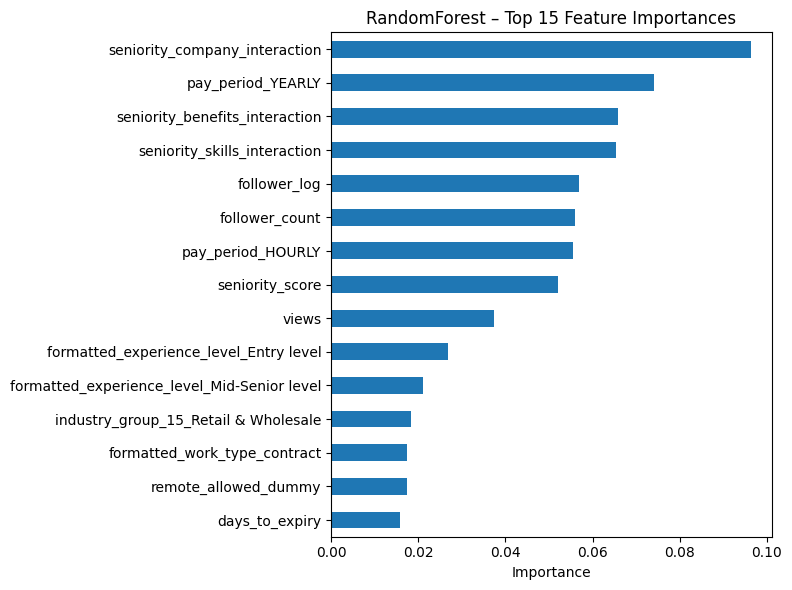

,importance
seniority_company_interaction,0.096352
pay_period_YEARLY,0.074129
seniority_benefits_interaction,0.065941
seniority_skills_interaction,0.065341
follower_log,0.056869
follower_count,0.055880
pay_period_HOURLY,0.055460
seniority_score,0.051987
views,0.037384
formatted_experience_level_Entry level,0.026831


In [85]:
# === Finalize best model (RandomForest) + plot top-15 feature importances ===
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes: X_train, X_test, y_train, y_test already exist
# Using df_clean implicitly because X was created from it earlier

cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    "n_estimators": [200],
    "max_depth": [20, None],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
gs = GridSearchCV(
    rf_base,
    param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

best_rf = gs.best_estimator_
pred = best_rf.predict(X_test)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("Best RF params:", gs.best_params_)
print("RF (final) R2:", r2)
print("RF (final) MAE:", mae)
print("RF (final) RMSE:", rmse)

# Feature importances – top 15
fi = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi_top15 = fi.head(15)

ax = fi_top15.sort_values().plot(kind="barh", figsize=(8, 6))
ax.set_title("RandomForest – Top 15 Feature Importances")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

best_model = best_rf
fi_top15_df = fi_top15.to_frame(name="importance")
display(fi_top15_df)


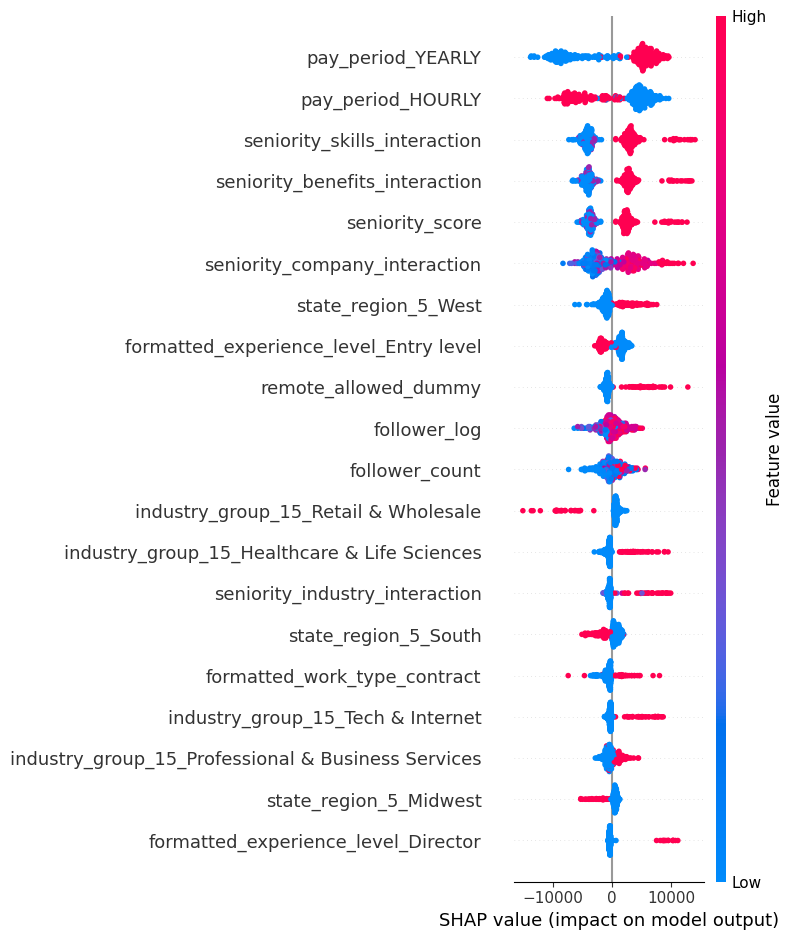

Saved SHAP summary as shap_summary.png


In [80]:
!pip install shap

import shap
import numpy as np

# Use only 400 rows for speed
sample_idx = np.random.choice(X_train.index, size=400, replace=False)
X_sample = X_train.loc[sample_idx]

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved SHAP summary as shap_summary.png")


In [88]:
df_final_model = df_clean.copy()

In [89]:
# import pickle

# with open("df_final_model.pkl", "wb") as f:
#     pickle.dump(df_final_model, f)

# print("Saved df_final_model.pkl in notebook directory.")

Saved df_final_model.pkl in notebook directory.


In [90]:
# from google.colab import drive
# drive.mount('/content/drive')

# with open('/content/drive/MyDrive/df_final_model.pkl', 'wb') as f:
#     pickle.dump(df_final_model, f)

# print("Saved df_final_model.pkl to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved df_final_model.pkl to Google Drive.


In [91]:
# from google.colab import files
# files.download("df_final_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>